In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import cv2 as cv
import numpy as np
from numba import cuda
from datetime import datetime

from utils import process_raw_data, draw_segmentation_mask

In [2]:
# Check if a GPU device is available
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
IMG_WIDTH = 640
IMG_HEIGHT = 480
IMG_CHANNELS = 3

num_classes = 3

In [4]:
# Contracting path
num_filters = 16
dropout_rate = 0.05

input = layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
c1 = layers.Conv2D(num_filters, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(input)
c1 = layers.Dropout(dropout_rate)(c1)
c1 = layers.Conv2D(num_filters, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(c1)
p1 = layers.MaxPool2D((2, 2), (2, 2))(c1)

c2 = layers.Conv2D(2*num_filters, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(p1)
c2 = layers.Dropout(dropout_rate)(c2)
c2 = layers.Conv2D(2*num_filters, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(c2)
p2 = layers.MaxPool2D((2, 2), (2, 2))(c2)

c3 = layers.Conv2D(4*num_filters, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(p2)
c3 = layers.Dropout(dropout_rate)(c3)
c3 = layers.Conv2D(4*num_filters, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(c3)
p3 = layers.MaxPool2D((2, 2), (2, 2))(c3)

c4 = layers.Conv2D(8*num_filters, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(p3)
c4 = layers.Dropout(dropout_rate)(c4)
c4 = layers.Conv2D(8*num_filters, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(c4)
p4 = layers.MaxPool2D((2, 2), (2, 2))(c4)

c5 = layers.Conv2D(16*num_filters, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(p4)
c5 = layers.Dropout(dropout_rate)(c5)
c5 = layers.Conv2D(16*num_filters, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(c5)

In [5]:
# Expanding path
u6 = layers.Conv2DTranspose(8*num_filters, (2, 2), (2, 2), padding="same")(c5)
c6 = layers.Concatenate(axis=3)([c4, u6])
c6 = layers.Conv2D(8*num_filters, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(c6)
c6 = layers.Dropout(dropout_rate)(c6)
c6 = layers.Conv2D(8*num_filters, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(c6)

u7 = layers.Conv2DTranspose(4*num_filters, (2, 2), (2, 2), padding="same")(c6)
c7 = layers.Concatenate(axis=3)([c3, u7])
c7 = layers.Conv2D(4*num_filters, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(c7)
c7 = layers.Dropout(dropout_rate)(c7)
c7 = layers.Conv2D(4*num_filters, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(c7)

u8 = layers.Conv2DTranspose(2*num_filters, (2, 2), (2, 2), padding="same")(c7)
c8 = layers.Concatenate(axis=3)([c2, u8])
c8 = layers.Conv2D(2*num_filters, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(c8)
c8 = layers.Dropout(dropout_rate)(c8)
c8 = layers.Conv2D(2*num_filters, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(c8)

u9 = layers.Conv2DTranspose(num_filters, (2, 2), (2, 2), padding="same")(c8)
c9 = layers.Concatenate(axis=3)([c1, u9])
c9 = layers.Conv2D(num_filters, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(c9)
c9 = layers.Dropout(dropout_rate)(c9)
c9 = layers.Conv2D(num_filters, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(c9)

output = layers.Conv2D(num_classes, (1, 1), activation="softmax")(c9)

In [6]:
unet_model = keras.Model(inputs=[input], outputs=[output])

optimizer = keras.optimizers.Adam(learning_rate=1e-5)
loss_function = keras.losses.CategoricalCrossentropy()

unet_model.compile(optimizer=optimizer, loss=loss_function, metrics=["accuracy"])
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 480, 640, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 480, 640, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [7]:
raw_data_path = "../data/raw_data/"
train_path = "../data/train/"
test_path = "../data/test/"

label_names = ["korov", "maticnjak"]
member_names = ["ivan", "mladen", "dino", "milan", "bojan"]

test_ratio = 0.1

process_raw_data(raw_data_path, train_path, test_path, member_names, label_names, test_ratio)

In [8]:
data_gen_args = dict(rotation_range=15,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     zoom_range=0.2,
                     fill_mode="reflect",
                     horizontal_flip=True,
                     vertical_flip=True,
                     rescale=1./255,
                     validation_split=0.2)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1

train_image_generator = image_datagen.flow_from_directory(
    train_path + "input/",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    batch_size=4,
    seed=seed,
    subset="training"
)

train_label_generator = mask_datagen.flow_from_directory(
    train_path + "output/",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    batch_size=4,
    seed=seed,
    subset="training"
)

train_generator = zip(train_image_generator, train_label_generator)

seed = 100

valid_image_generator = image_datagen.flow_from_directory(
    train_path + "input/",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    batch_size=4,
    seed=seed,
    subset="validation"
)

valid_label_generator = mask_datagen.flow_from_directory(
    train_path + "output/",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    batch_size=4,
    seed=seed,
    subset="validation"
)

validation_generator = zip(train_image_generator, train_label_generator)

Found 8 images belonging to 1 classes.
Found 8 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.


In [9]:
now = datetime.now()
log_dir = "tf_logs/" + now.strftime("%Y%m%d-%H%M%S") + "/"

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
    keras.callbacks.ModelCheckpoint(filepath="../saved_models/unet_model.h5", save_best_only=True),
    keras.callbacks.TensorBoard(log_dir=log_dir)
]

In [10]:
unet_model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=100, 
    validation_data=validation_generator,
    validation_steps=2,
    callbacks=callbacks
)

Epoch 1/10
100/100 [==============================] - 133s 1s/step - loss: 1.0451 - accuracy: 0.4225 - val_loss: 1.0057 - val_accuracy: 0.4966
Epoch 2/10
100/100 [==============================] - 111s 1s/step - loss: 0.8615 - accuracy: 0.5909 - val_loss: 0.9020 - val_accuracy: 0.6566
Epoch 3/10
100/100 [==============================] - 111s 1s/step - loss: 0.6097 - accuracy: 0.7946 - val_loss: 1.3231 - val_accuracy: 0.3957
Epoch 4/10
100/100 [==============================] - 111s 1s/step - loss: 0.4320 - accuracy: 0.8575 - val_loss: 1.1373 - val_accuracy: 0.5862
Epoch 5/10
100/100 [==============================] - 111s 1s/step - loss: 0.3658 - accuracy: 0.8777 - val_loss: 1.5823 - val_accuracy: 0.4635
Epoch 6/10
100/100 [==============================] - 111s 1s/step - loss: 0.3406 - accuracy: 0.8842 - val_loss: 1.4896 - val_accuracy: 0.5018
Epoch 7/10
100/100 [==============================] - 111s 1s/step - loss: 0.3145 - accuracy: 0.8926 - val_loss: 1.2121 - val_accuracy: 0.5716

In [11]:
test_image_datagen = ImageDataGenerator(rescale=1./255)
test_mask_datagen = ImageDataGenerator(rescale=1./255)

test_image_generator = test_image_datagen.flow_from_directory(
    test_path + "input/",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    batch_size=1
)

test_mask_generator = test_mask_datagen.flow_from_directory(
    test_path + "output/",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    batch_size=1
)

test_generator = zip(test_image_generator, test_mask_generator)

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.


In [12]:
unet_model.evaluate(test_generator, steps=1)

1/1 [==============================] - 6s 6s/step - loss: 0.9163 - accuracy: 0.7132


[0.9162945747375488, 0.7132486701011658]

In [13]:
img, mask_true = next(validation_generator)

pred = unet_model.predict(img)
mask = tf.one_hot(tf.argmax(pred, axis=3), depth=num_classes)

img_pred = draw_segmentation_mask(np.uint8(img[0]*255), mask[0], 0.3)

cv.imshow("img", cv.cvtColor(img_pred, cv.COLOR_RGB2BGR))
cv.waitKey()
cv.destroyAllWindows()

img_true = draw_segmentation_mask(np.uint8(img[0]*255), np.round(mask_true[0]), 0.3)
cv.imshow("img", cv.cvtColor(img_true, cv.COLOR_RGB2BGR))
cv.waitKey()
cv.destroyAllWindows()

1/1 [==============================] - 0s 359ms/step


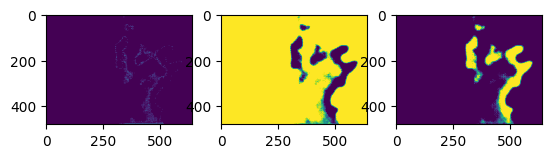

In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3)

axes[0].imshow(mask[0, :, :, 0])
axes[1].imshow(mask[0, :, :, 1])
axes[2].imshow(mask[0, :, :, 2])

In [15]:
# cuda.select_device(0)
# cuda.close()